In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

# Import des donneés

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Save train
X_train = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/X_train.npy', allow_pickle=True)
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/y_train.npy', allow_pickle=True)
# Save validation
X_val = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/X_val.npy', allow_pickle=True)
y_val = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/y_val.npy', allow_pickle=True)
# Save test
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/X_test.npy', allow_pickle=True)
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/y_test.npy', allow_pickle=True)

In [4]:
X_train.shape, X_val.shape, X_test.shape

((1749, 224, 224, 3), (375, 224, 224, 3), (376, 224, 224, 3))

In [5]:
y_train.shape, y_val.shape, y_test.shape

((1749, 5), (375, 5), (376, 5))

In [6]:
from skimage import exposure
# Histogram equalization
def histogram_equalization(img):
    for channel in range(img.shape[2]):  # equalizing each channel
        img[:, :, channel] = exposure.equalize_hist(img[:, :, channel])
    return img
def reformat_images(arr):
    for idx in range(arr.shape[0]):
        arr[idx] = histogram_equalization(arr[idx])
    return arr

In [7]:
X_train = reformat_images(X_train)
X_val = reformat_images(X_val)
X_test = reformat_images(X_test)

In [8]:
X_train.shape, X_val.shape, X_test.shape

((1749, 224, 224, 3), (375, 224, 224, 3), (376, 224, 224, 3))

# Evaluation des modèles

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import plot_model

with open('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/saved_model/label_bin.pkl', 'rb') as f:
    lb = pickle.load(f)

display(lb.classes_)

def evaluate_model(model, X_test, y_test, lb):
    ### Predict
    y_pred = [lb.classes_[np.argmax(model.predict(np.expand_dims(_X_test, axis=0)))] for _X_test in X_test]

    #Get the confusion matrix
    cf_matrix = confusion_matrix(lb.inverse_transform(y_test), y_pred)

    plt.figure(figsize=(8,8))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Breed')
    ax.set_ylabel('Expected Breed');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(lb.classes_, rotation=90)
    ax.yaxis.set_ticklabels(lb.classes_, rotation=0)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    ### Scores
    print('\n\n')
    print(classification_report(y_test,lb.transform(y_pred)))

def plot_training(history):
    plt.subplot()
    plt.title('Model Accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training Accuracy','Validation Accuracy'])
    plt.show()

    plt.title('Model Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training Loss','Validation Loss'])
    plt.show()

def model_report(model, history, X_test, y_test, lb):
    #plot_model(model, show_shapes=True)
    print(model.summary())
    plot_training(history)
    evaluate_model(model, X_test, y_test, lb)

array(['afghan_hound', 'maltese_dog', 'pomeranian', 'samoyed',
       'scottish_deerhound'], dtype='<U18')

# Parametrage

In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D, Conv2D, GlobalMaxPooling2D, LeakyReLU
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

## Parametres
epochs = 50
batch_size = 64

opt = Adam(learning_rate=1e-3)

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1, 
    mode='auto'
)

callbacks = [earlystop, reduceLR]

#From Scratch Resnet


## Choix layer transition Convolution vers classification

### Layer Flatten

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 27s 451ms/step - loss: 13.0186 - accuracy: 0.3533 - val_loss: 1.7208 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 9s 353ms/step - loss: 1.6071 - accuracy: 0.6101 - val_loss: 1903.0287 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 10s 358ms/step - loss: 0.7822 - accuracy: 0.6638 - val_loss: 1.6167 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 10s 362ms/step - loss: 0.6437 - accuracy: 0.7261 - val_loss: 1.5971 - val_accuracy: 0.3467 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 10s 357ms/step - loss: 0.5164 - accuracy: 0.8062 - val_loss: 1.5906 - val_accuracy: 0.3120 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 9s 352ms/step - loss: 0.3397 - accuracy: 0.9011 - val_loss: 1.5528 - val_accuracy: 0.3760

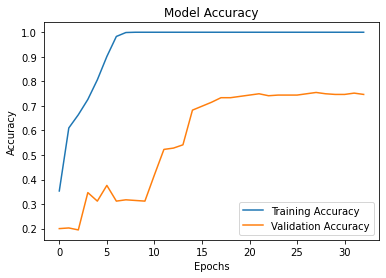

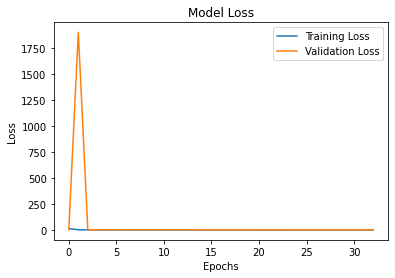

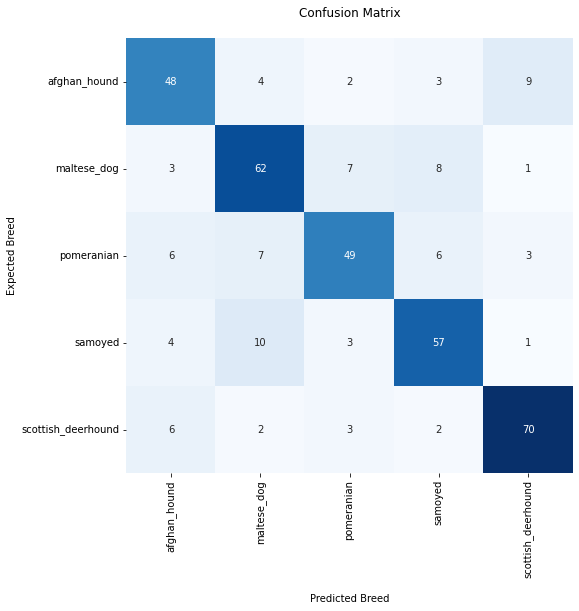




              precision    recall  f1-score   support

           0       0.72      0.73      0.72        66
           1       0.73      0.77      0.75        81
           2       0.77      0.69      0.73        71
           3       0.75      0.76      0.75        75
           4       0.83      0.84      0.84        83

   micro avg       0.76      0.76      0.76       376
   macro avg       0.76      0.76      0.76       376
weighted avg       0.76      0.76      0.76       376
 samples avg       0.76      0.76      0.76       376



In [14]:
print("[INFO] creating model...")
baseModel = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

### Layer GlobalAveragePooling

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 16s 419ms/step - loss: 1.5856 - accuracy: 0.6272 - val_loss: 1.6504 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 9s 352ms/step - loss: 0.6683 - accuracy: 0.7456 - val_loss: 2.1112 - val_accuracy: 0.3440 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 9s 352ms/step - loss: 0.4358 - accuracy: 0.8239 - val_loss: 3.7339 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 9s 353ms/step - loss: 0.2938 - accuracy: 0.8925 - val_loss: 2.4927 - val_accuracy: 0.3120 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 10s 375ms/step - loss: 0.4338 - accuracy: 0.8411 - val_loss: 3.5609 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.8971
Epoch 6: ReduceLROnPlateau reducing learning rate to 

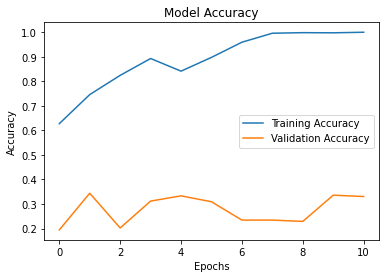

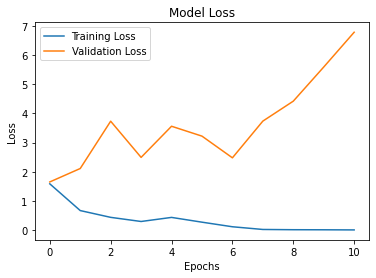

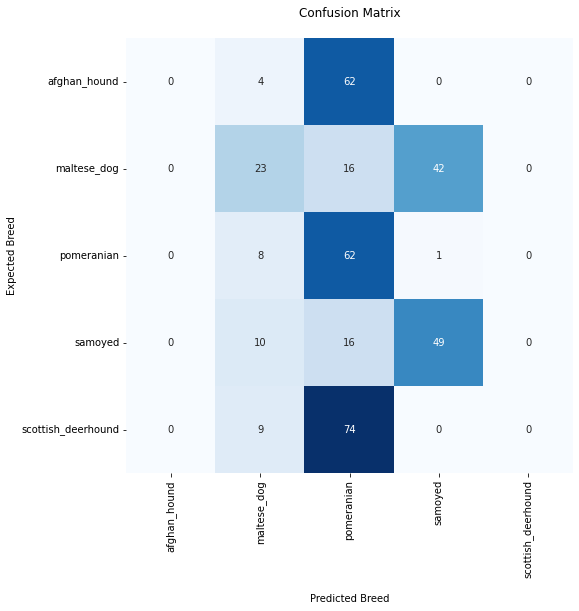




              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.43      0.28      0.34        81
           2       0.27      0.87      0.41        71
           3       0.53      0.65      0.59        75
           4       0.00      0.00      0.00        83

   micro avg       0.36      0.36      0.36       376
   macro avg       0.25      0.36      0.27       376
weighted avg       0.25      0.36      0.27       376
 samples avg       0.36      0.36      0.36       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
print("[INFO] creating model...")
baseModel = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalAveragePooling2D(name="global_average_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

### Layer GlobalMaxPooling

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 16s 396ms/step - loss: 3.6153 - accuracy: 0.5249 - val_loss: 1.6512 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 10s 375ms/step - loss: 0.8276 - accuracy: 0.6844 - val_loss: 1.6334 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 10s 375ms/step - loss: 0.6304 - accuracy: 0.7353 - val_loss: 1.6760 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 9s 352ms/step - loss: 0.5028 - accuracy: 0.7999 - val_loss: 1.6569 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 9s 352ms/step - loss: 0.3881 - accuracy: 0.8571 - val_loss: 1.6505 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 10s 376ms/step - loss: 0.3408 - accuracy: 0.8685 - val_loss: 1.6998 - val_accuracy: 0.2080 - l

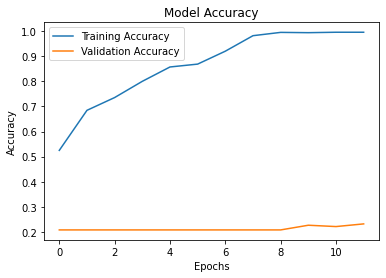

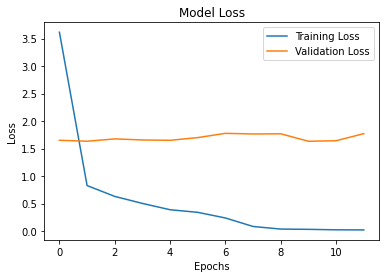

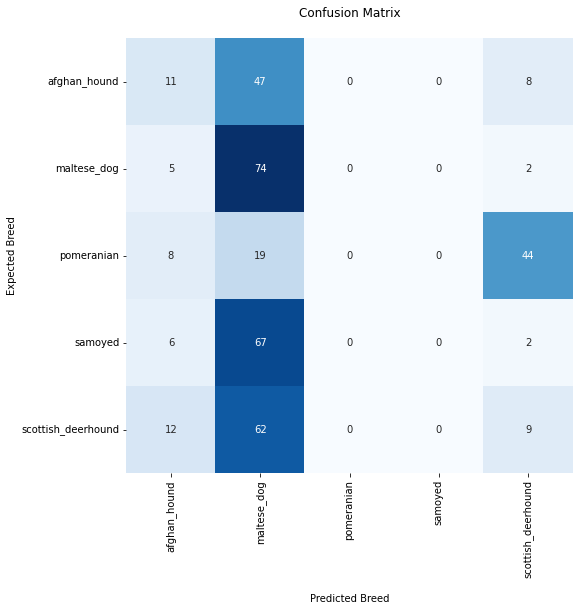




              precision    recall  f1-score   support

           0       0.26      0.17      0.20        66
           1       0.28      0.91      0.42        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.14      0.11      0.12        83

   micro avg       0.25      0.25      0.25       376
   macro avg       0.14      0.24      0.15       376
weighted avg       0.14      0.25      0.15       376
 samples avg       0.25      0.25      0.25       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print("[INFO] creating model...")
baseModel = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalMaxPooling2D(name="global_max_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

#### <i>Test : Augmentation Dropout pour contrer l'overfit</i>

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 17s 440ms/step - loss: 6.2926 - accuracy: 0.4723 - val_loss: 1.7683 - val_accuracy: 0.1920 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 10s 358ms/step - loss: 2.8392 - accuracy: 0.6644 - val_loss: 1.8072 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 9s 351ms/step - loss: 2.1995 - accuracy: 0.6718 - val_loss: 1.7942 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 10s 355ms/step - loss: 2.0535 - accuracy: 0.6792 - val_loss: 1.8824 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 9s 351ms/step - loss: 2.0537 - accuracy: 0.6804 - val_loss: 1.8891 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - ETA: 0s - loss: 1.8785 - accuracy: 0.6775
Epoch 6: ReduceLROnPlateau reducing learning rate to

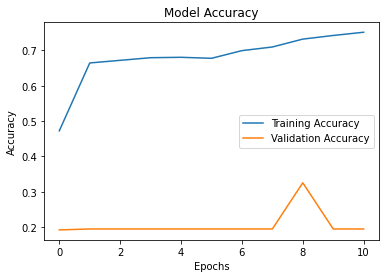

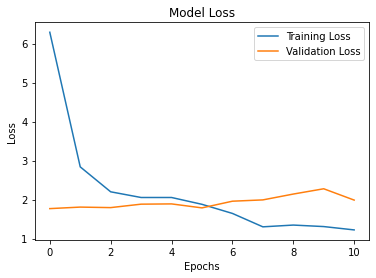

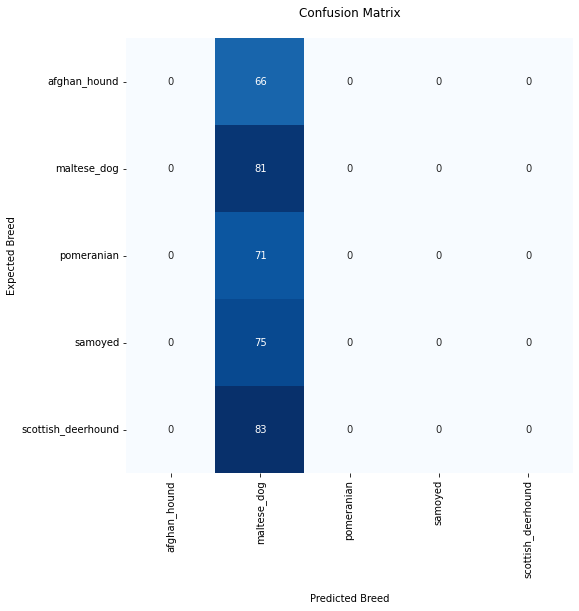




              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.22      1.00      0.35        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.22      0.22      0.22       376
   macro avg       0.04      0.20      0.07       376
weighted avg       0.05      0.22      0.08       376
 samples avg       0.22      0.22      0.22       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
print("[INFO] creating model...")
baseModel = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalMaxPooling2D(name="global_max_pooling2d")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

## Ajout Layer classification

### Ajout de Dense layers
    - Dense(4096, activation ='relu')
    - Dense(4096, activation ='relu')

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 18s 458ms/step - loss: 112.1702 - accuracy: 0.1835 - val_loss: 87.0499 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 11s 416ms/step - loss: 3.1437 - accuracy: 0.2081 - val_loss: 2.1638 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 11s 414ms/step - loss: 2.2735 - accuracy: 0.2773 - val_loss: 1.6145 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 11s 414ms/step - loss: 1.6298 - accuracy: 0.4420 - val_loss: 1.6157 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 11s 415ms/step - loss: 1.0867 - accuracy: 0.5523 - val_loss: 1.6238 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 12s 435ms/step - loss: 0.8978 - accuracy: 0.6306 - val_loss: 1.6218 - val_accuracy: 0.202

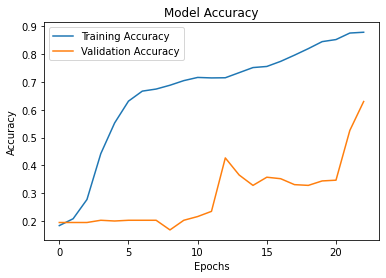

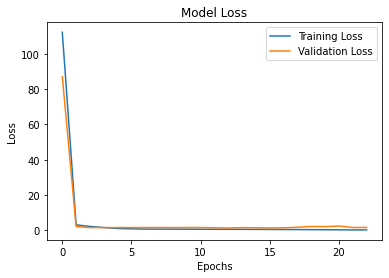

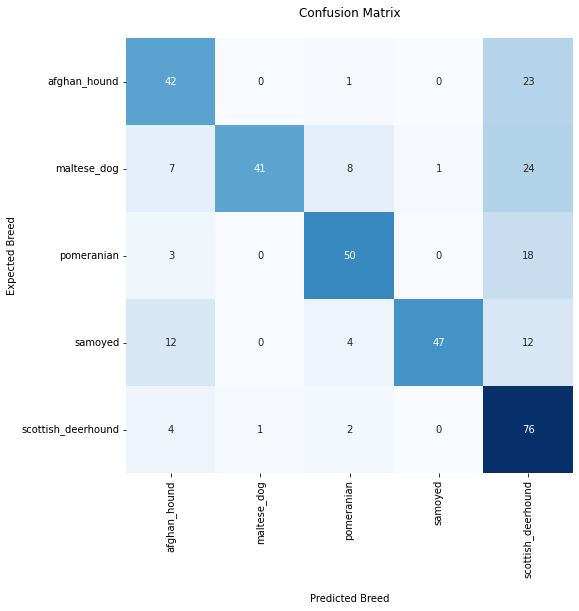




              precision    recall  f1-score   support

           0       0.62      0.64      0.63        66
           1       0.98      0.51      0.67        81
           2       0.77      0.70      0.74        71
           3       0.98      0.63      0.76        75
           4       0.50      0.92      0.64        83

   micro avg       0.68      0.68      0.68       376
   macro avg       0.77      0.68      0.69       376
weighted avg       0.77      0.68      0.69       376
 samples avg       0.68      0.68      0.68       376



In [18]:
print("[INFO] creating model...")
baseModel = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4096, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4096, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

### Ajout de Dense layers
    - Dense(4096, activation ='relu')
    - Dense(1024, activation ='relu')

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 26s 517ms/step - loss: 83.5724 - accuracy: 0.2287 - val_loss: 140.5518 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 11s 410ms/step - loss: 6.5042 - accuracy: 0.2573 - val_loss: 12.0810 - val_accuracy: 0.2240 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 11s 413ms/step - loss: 3.8068 - accuracy: 0.3082 - val_loss: 1.6117 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 11s 417ms/step - loss: 2.3141 - accuracy: 0.3596 - val_loss: 1.6114 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 12s 432ms/step - loss: 1.2223 - accuracy: 0.5660 - val_loss: 1.6205 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 11s 411ms/step - loss: 0.8787 - accuracy: 0.6638 - val_loss: 1.6707 - val_accuracy: 0.20

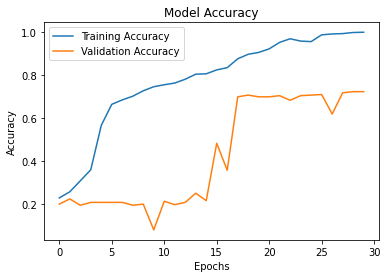

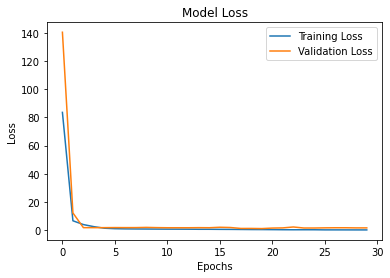

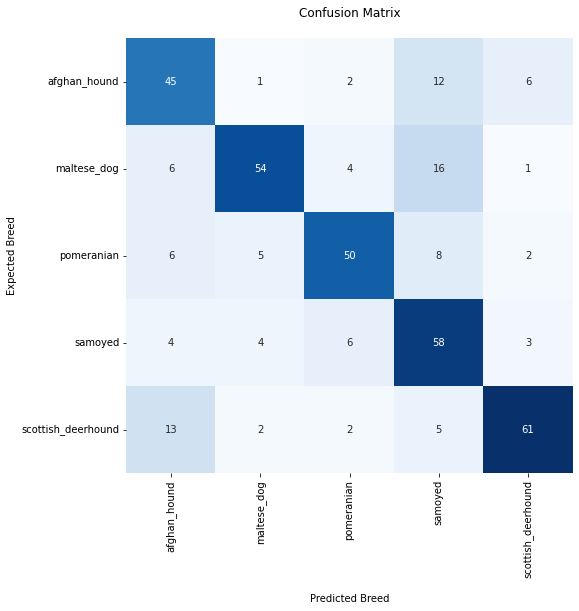




              precision    recall  f1-score   support

           0       0.61      0.68      0.64        66
           1       0.82      0.67      0.73        81
           2       0.78      0.70      0.74        71
           3       0.59      0.77      0.67        75
           4       0.84      0.73      0.78        83

   micro avg       0.71      0.71      0.71       376
   macro avg       0.73      0.71      0.71       376
weighted avg       0.73      0.71      0.72       376
 samples avg       0.71      0.71      0.71       376



In [13]:
print("[INFO] creating model...")
baseModel = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4096, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

## Fonction d'activation Dense Layer

### Modification fonction d'activation 'leakyrelu'
    - Dense(4096, activation ='leakyrelu')
    - Dense(1024, activation ='leakyrelu')

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 27s 506ms/step - loss: 241.3718 - accuracy: 0.2138 - val_loss: 283954.1562 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 11s 411ms/step - loss: 10.4832 - accuracy: 0.3545 - val_loss: 16017.5645 - val_accuracy: 0.1840 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 11s 412ms/step - loss: 6.0072 - accuracy: 0.4317 - val_loss: 3.9879 - val_accuracy: 0.2240 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 12s 431ms/step - loss: 1.3114 - accuracy: 0.4351 - val_loss: 1.6570 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 11s 411ms/step - loss: 1.1696 - accuracy: 0.4969 - val_loss: 1.6332 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 11s 411ms/step - loss: 0.9750 - accuracy: 0.6541 - val_loss: 1.4845 - val_accura

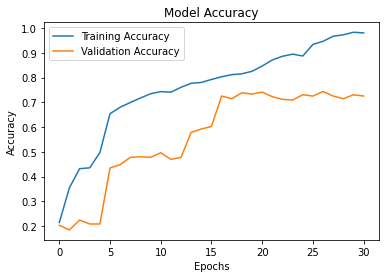

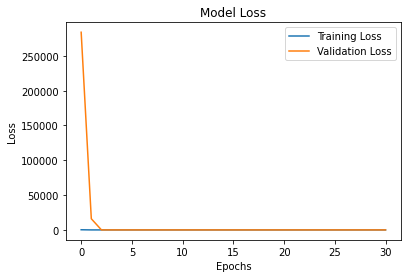

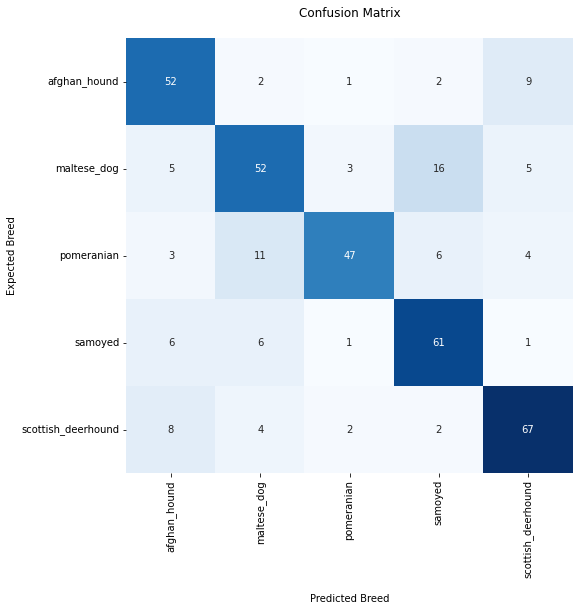




              precision    recall  f1-score   support

           0       0.70      0.79      0.74        66
           1       0.69      0.64      0.67        81
           2       0.87      0.66      0.75        71
           3       0.70      0.81      0.75        75
           4       0.78      0.81      0.79        83

   micro avg       0.74      0.74      0.74       376
   macro avg       0.75      0.74      0.74       376
weighted avg       0.75      0.74      0.74       376
 samples avg       0.74      0.74      0.74       376



In [12]:
print("[INFO] creating model...")
baseModel = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4096, activation=None)(headModel)
headModel = LeakyReLU()(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(1024, activation=None)(headModel)
headModel = LeakyReLU()(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

### Modification fonction d'activation 'selu'
    - Dense(4096, activation ='selu')
    - Dense(1024, activation ='selu')

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 15s 511ms/step - loss: 1.6130 - accuracy: 0.1915 - val_loss: 1.6101 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 13s 491ms/step - loss: 1.6103 - accuracy: 0.1973 - val_loss: 1.6096 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6097 - accuracy: 0.1887 - val_loss: 1.6094 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6103 - accuracy: 0.1835 - val_loss: 1.6095 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6096 - accuracy: 0.1910 - val_loss: 1.6093 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6093 - accuracy: 0.2001 - val_loss: 1.6094 - val_accuracy: 0.2080 -

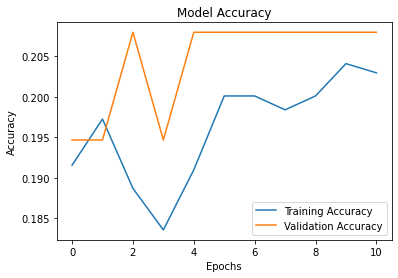

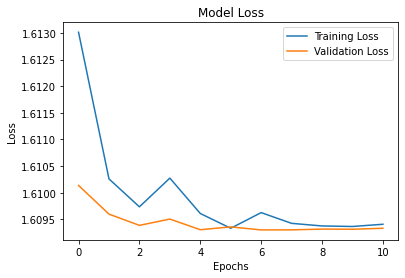

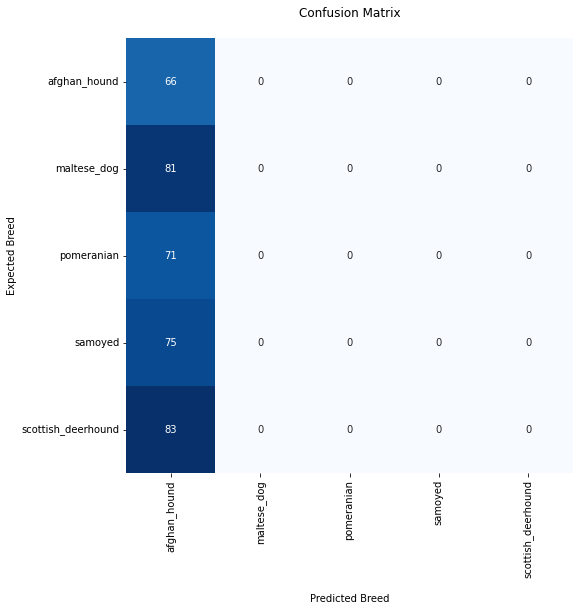




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("[INFO] creating model...")
baseModel = ResNet50(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4096, activation="selu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(1024, activation="selu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

#Transfer learning Resnet (imagenet)

## Meilleur model from scratch avec import poids "imagenet"

[INFO] creating model...
94781440/94765736 [==============================] - 1s 0us/step
[INFO] freeze weights...
- [input_2] : train_state -> False
- [conv1_pad] : train_state -> False
- [conv1_conv] : train_state -> False
- [conv1_bn] : train_state -> False
- [conv1_relu] : train_state -> False
- [pool1_pad] : train_state -> False
- [pool1_pool] : train_state -> False
- [conv2_block1_1_conv] : train_state -> False
- [conv2_block1_1_bn] : train_state -> False
- [conv2_block1_1_relu] : train_state -> False
- [conv2_block1_2_conv] : train_state -> False
- [conv2_block1_2_bn] : train_state -> False
- [conv2_block1_2_relu] : train_state -> False
- [conv2_block1_0_conv] : train_state -> False
- [conv2_block1_3_conv] : train_state -> False
- [conv2_block1_0_bn] : train_state -> False
- [conv2_block1_3_bn] : train_state -> False
- [conv2_block1_add] : train_state -> False
- [conv2_block1_out] : train_state -> False
- [conv2_block2_1_conv] : train_state -> False
- [conv2_block2_1_bn] : train

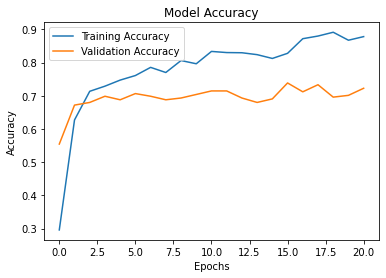

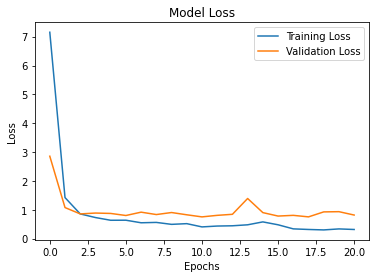

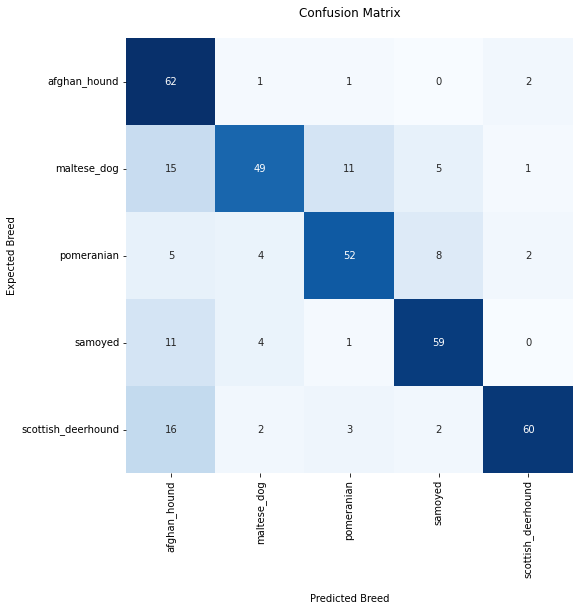




              precision    recall  f1-score   support

           0       0.57      0.94      0.71        66
           1       0.82      0.60      0.70        81
           2       0.76      0.73      0.75        71
           3       0.80      0.79      0.79        75
           4       0.92      0.72      0.81        83

   micro avg       0.75      0.75      0.75       376
   macro avg       0.77      0.76      0.75       376
weighted avg       0.78      0.75      0.75       376
 samples avg       0.75      0.75      0.75       376



In [13]:
print("[INFO] creating model...")
baseModel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] freeze weights...")
baseModel.trainable = False
for layer in model.layers:
    print(f'- [{layer.name}] : train_state -> {layer.trainable}')
print("[INFO] Resnet weights frozen...")

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

## Fine-Tuning Step 1

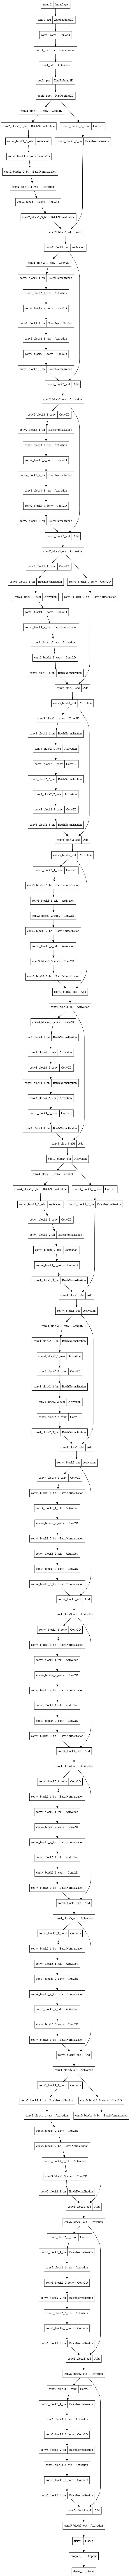

In [14]:
plot_model(model)

[INFO] unfreeze conv5_block3 weights...
- [input_2] : train_state -> False
- [conv1_pad] : train_state -> False
- [conv1_conv] : train_state -> False
- [conv1_bn] : train_state -> False
- [conv1_relu] : train_state -> False
- [pool1_pad] : train_state -> False
- [pool1_pool] : train_state -> False
- [conv2_block1_1_conv] : train_state -> False
- [conv2_block1_1_bn] : train_state -> False
- [conv2_block1_1_relu] : train_state -> False
- [conv2_block1_2_conv] : train_state -> False
- [conv2_block1_2_bn] : train_state -> False
- [conv2_block1_2_relu] : train_state -> False
- [conv2_block1_0_conv] : train_state -> False
- [conv2_block1_3_conv] : train_state -> False
- [conv2_block1_0_bn] : train_state -> False
- [conv2_block1_3_bn] : train_state -> False
- [conv2_block1_add] : train_state -> False
- [conv2_block1_out] : train_state -> False
- [conv2_block2_1_conv] : train_state -> False
- [conv2_block2_1_bn] : train_state -> False
- [conv2_block2_1_relu] : train_state -> False
- [conv2_blo

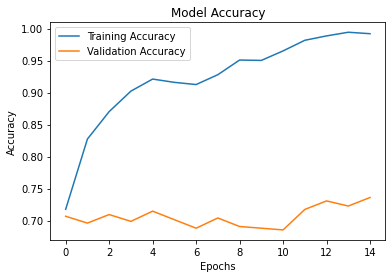

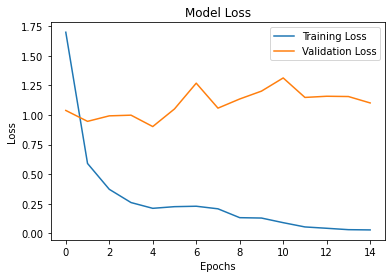

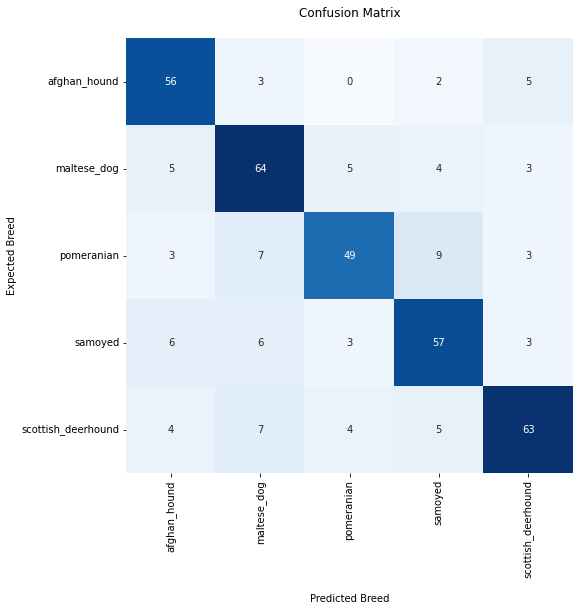




              precision    recall  f1-score   support

           0       0.76      0.85      0.80        66
           1       0.74      0.79      0.76        81
           2       0.80      0.69      0.74        71
           3       0.74      0.76      0.75        75
           4       0.82      0.76      0.79        83

   micro avg       0.77      0.77      0.77       376
   macro avg       0.77      0.77      0.77       376
weighted avg       0.77      0.77      0.77       376
 samples avg       0.77      0.77      0.77       376



In [16]:
print("[INFO] unfreeze conv5_block3 weights...")

for layer in model.layers:
    if layer.name.__contains__('conv5_block3'):
        layer.trainable = True
    print(f'- [{layer.name}] : train_state -> {layer.trainable}')

print("[INFO] re-compiling model...")
opt = Adam(learning_rate=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=20, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

## Fine-Tuning Step 2

[INFO] unfreeze conv5_block2 weights...
- [input_2] : train_state -> False
- [conv1_pad] : train_state -> False
- [conv1_conv] : train_state -> False
- [conv1_bn] : train_state -> False
- [conv1_relu] : train_state -> False
- [pool1_pad] : train_state -> False
- [pool1_pool] : train_state -> False
- [conv2_block1_1_conv] : train_state -> False
- [conv2_block1_1_bn] : train_state -> False
- [conv2_block1_1_relu] : train_state -> False
- [conv2_block1_2_conv] : train_state -> False
- [conv2_block1_2_bn] : train_state -> False
- [conv2_block1_2_relu] : train_state -> False
- [conv2_block1_0_conv] : train_state -> False
- [conv2_block1_3_conv] : train_state -> False
- [conv2_block1_0_bn] : train_state -> False
- [conv2_block1_3_bn] : train_state -> False
- [conv2_block1_add] : train_state -> False
- [conv2_block1_out] : train_state -> False
- [conv2_block2_1_conv] : train_state -> False
- [conv2_block2_1_bn] : train_state -> False
- [conv2_block2_1_relu] : train_state -> False
- [conv2_blo

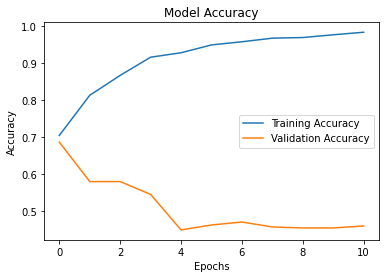

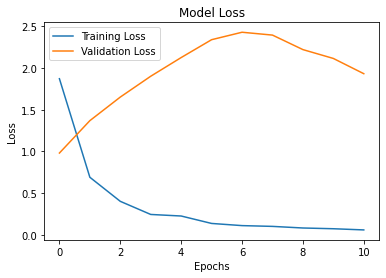

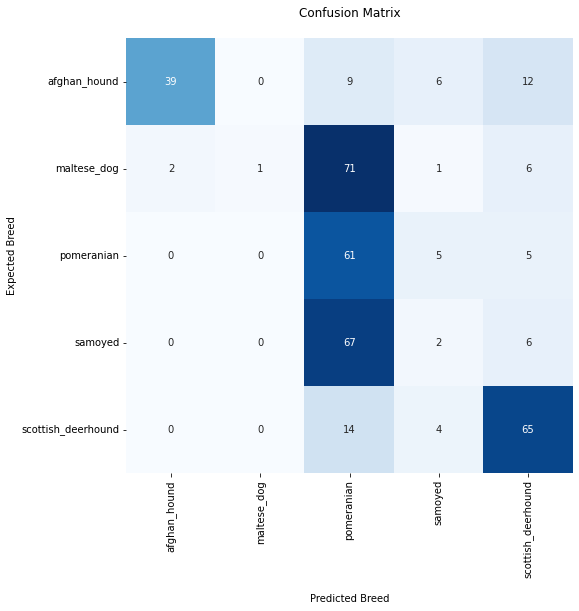




              precision    recall  f1-score   support

           0       0.95      0.59      0.73        66
           1       1.00      0.01      0.02        81
           2       0.27      0.86      0.42        71
           3       0.11      0.03      0.04        75
           4       0.69      0.78      0.73        83

   micro avg       0.45      0.45      0.45       376
   macro avg       0.61      0.45      0.39       376
weighted avg       0.61      0.45      0.38       376
 samples avg       0.45      0.45      0.45       376



In [17]:
print("[INFO] unfreeze conv5_block2 weights...")

for layer in model.layers:
    if layer.name.__contains__('conv5_block2'):
        layer.trainable = True
    print(f'- [{layer.name}] : train_state -> {layer.trainable}')

print("[INFO] re-compiling model...")
opt = Adam(learning_rate=1e-5)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=20, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)